<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparing-the-data" data-toc-modified-id="Preparing-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparing the data</a></span></li><li><span><a href="#Training-a-binary-classifier-(for-digit-5)" data-toc-modified-id="Training-a-binary-classifier-(for-digit-5)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Training a binary classifier (for digit 5)</a></span></li><li><span><a href="#Performance-measures" data-toc-modified-id="Performance-measures-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Performance measures</a></span></li><li><span><a href="#ROC-Curve-(Receiver-Operating-Characteristic)" data-toc-modified-id="ROC-Curve-(Receiver-Operating-Characteristic)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>ROC Curve (Receiver Operating Characteristic)</a></span></li><li><span><a href="#Multiclass-classification-(multinomial)" data-toc-modified-id="Multiclass-classification-(multinomial)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Multiclass classification (multinomial)</a></span></li><li><span><a href="#Multi-Label-classification" data-toc-modified-id="Multi-Label-classification-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Multi-Label classification</a></span></li><li><span><a href="#Multi-output-classification" data-toc-modified-id="Multi-output-classification-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Multi-output classification</a></span></li></ul></div>

# Book - Classification (Chapter 3)

## Preparing the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import mnist
import scipy.misc

copy https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat ito sci kit data home dir

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


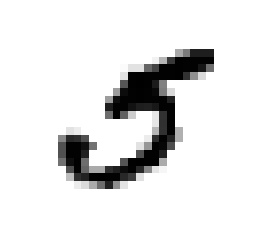

In [4]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation = 'nearest')
plt.axis('off')
plt.show()

In [5]:
y[36000]

5.0

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let's shuffle the train set to have good sampling

In [7]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a binary classifier (for digit 5)

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Let's begin with a Stochastic Gradient Descent classifier (SGD) which is appropriate for a lot of data and treating independently one by one each of the training data

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

## Performance measures

Implementing our own cross validation

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9659
0.9594
0.96435


In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9659 , 0.9594 , 0.96435])

95% each time seems amazing
Let's try to build a classifier that always tells False...

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9073 , 0.9087 , 0.91295])

This is what happens with imbalanced classes.
Another approach is the confusion matrix

In [15]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[54111,   468],
       [ 1739,  3682]], dtype=int64)

<b>precision</b> = TP / (TP + FP) <br>
<b>recall</b> (sensibilité, rappel) ou TPR (True Positive Rate) = TP / (TP + FN)

In [17]:
from sklearn.metrics import precision_score, recall_score
print('precision: {}\nrecall: {}' .format(precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)))

precision: 0.8872289156626506
recall: 0.6792104777716288


In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7694075854142723

In [19]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([76159.54061193])

In [20]:
treshold = 0
y_some_digit_pred = (y_scores > treshold)
y_some_digit_pred

array([ True])

In [21]:
treshold = 200000
y_some_digit_pred = (y_scores > treshold)
y_some_digit_pred

array([False])

How to find the good treshold ? Let's find decision function for all observations

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method='decision_function')

In [23]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, tresholds = precision_recall_curve(y_train_5, y_scores)

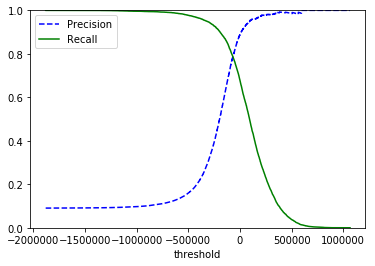

In [24]:
def plot_precision_recall_vs_treshold (precisions, recalls, tresholds):
    plt.plot(tresholds, precisions[:-1], 'b--', label = 'Precision')
    plt.plot(tresholds, recalls[:-1], 'g-', label = 'Recall')
    plt.xlabel('threshold')
    plt.legend(loc = 'upper left')
    plt.ylim([0, 1])
plot_precision_recall_vs_treshold (precisions, recalls, tresholds)
plt.show()

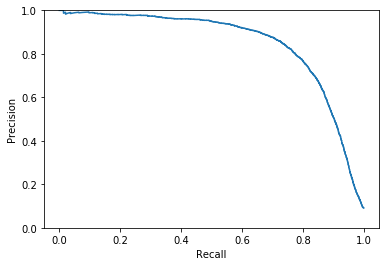

In [25]:
plt.plot(recalls, precisions)
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [26]:
y_pred_90 = (y_scores > 70000)

In [27]:
precision_score(y_train_5, y_pred_90)

0.9377370417193426

In [28]:
recall_score(y_train_5, y_pred_90)

0.5473159933591588

## ROC Curve (Receiver Operating Characteristic)
Courbe d'efficacité du récepteur, often used with binary classification
combines True positive rate (recall) with False positive rate (FPR)
FPR = 1 - TNR , also called sensibility

In [29]:
from sklearn.metrics import roc_curve
fpr, tpr, tresholds = roc_curve(y_train_5, y_scores)

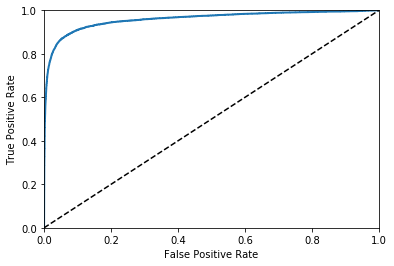

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr,tpr)
plt.show()

The Area Under the Curve (AUC ROC) of a perfect classifier is equal to 1 while a random classifier would give 0.5

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.95920557863862

In [32]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [33]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, tresholds_forest = roc_curve(y_train_5, y_scores_forest)

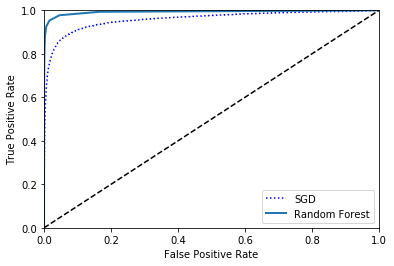

In [34]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')
plt.show()

In [35]:
roc_auc_score(y_train_5, y_scores_forest)

0.9929379389063662

## Multiclass classification (multinomial)

In [36]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

In [37]:
some_digit_score = sgd_clf.decision_function([some_digit])

In [38]:
np.argmax(some_digit_score)

5

In [39]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [40]:
sgd_clf.classes_[5]

5.0

In [41]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Victor\Anaconda3\lib\

C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Victor\Anaconda3\lib\

C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\Victor\Anaconda3\lib\

array([5.])

In [42]:
len(ovo_clf.estimators_)

45

In [43]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [44]:
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [45]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.85952809, 0.86034302, 0.85412812])

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.90756849, 0.9099955 , 0.91053658])

In [47]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

In [48]:
conf_mx

array([[5562,    2,   79,   17,   32,   28,   82,    3,  103,   15],
       [   3, 6485,   55,   25,   10,   24,   22,   14,   81,   23],
       [  29,   89, 5123,  154,   61,   16,  106,   67,  288,   25],
       [  30,   32,  321, 4963,   26,  207,   32,   61,  310,  149],
       [  12,   18,   57,   16, 5105,   24,   98,   18,  221,  273],
       [  80,   41,  117,  221,  149, 3924,  159,   25,  558,  147],
       [  46,   25,   98,   10,   63,   40, 5550,    6,   78,    2],
       [  24,   23,   97,   57,   92,   13,    7, 5498,   49,  405],
       [  59,  154,  302,  188,   99,  180,   90,   23, 4572,  184],
       [  35,   24,   50,  111,  368,   53,   14,  314,  282, 4698]],
      dtype=int64)

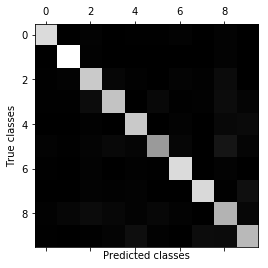

In [49]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.ylabel('True classes')
plt.xlabel('Predicted classes')
plt.show()

Now, let's divide each value by the number of occurences of the class, to avoid penalizing classes that occur often

In [50]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

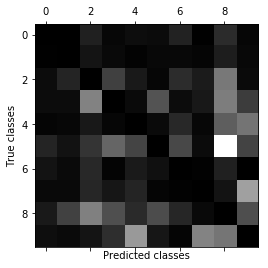

In [51]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.ylabel('True classes')
plt.xlabel('Predicted classes')
plt.show()

In [52]:
cl_a, cl_b = 5, 8
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
## And then we plot them

## Multi-Label classification

In [53]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [54]:
knn_clf.predict([some_digit])

array([[False,  True]])

To evaluate a multilabel classifier, we can average a metric for each label (ex: F1 score).

<b>macro</b> gives same importance to each label, but we can also use <b>weighted</b> or others.. (Don't run, very looong)

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_train, y_train_knn_pred, average='macro')

## Multi-output classification
Multi label and multi class

In [56]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_noise = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_noise = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

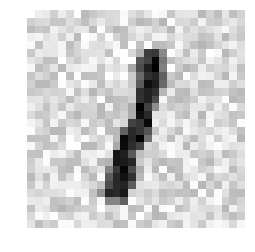

In [57]:
plt.imshow(X_train_noise[0].reshape(28,28), cmap=matplotlib.cm.binary, interpolation = 'nearest')
plt.axis('off')
plt.show()

In [64]:
knn_clf.fit(X_train_noise, y_train_mod)
result = knn_clf.predict(X_train_noise[0].reshape(1,-1))

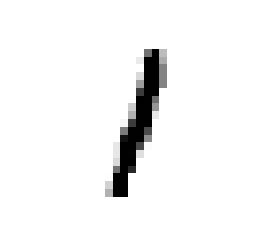

In [65]:
plt.imshow(result.reshape(28,28), cmap=matplotlib.cm.binary, interpolation = 'nearest')
plt.axis('off')
plt.show()